# Ising model as Perception-Action Loop

Description: Interpreting Ising model as perception-action loop to compare different intrinsic utility measures. Measures include:

- predictive information
- empowerment
- variational free energy (active inference), intrinsic component only
- thermodynamic efficiency

## 1. Simulation
Simulate the process of magnetization based on 2D Ising model, assume no external magnetic field. Use Metroplolis Algorithm.

In [1]:
# -*- coding: utf-8 -*-
from jpype import *
import sys
import numpy as np
from collections import defaultdict # to compute pdf
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
import plotly.graph_objs as go
from plotly.offline import plot
from scipy.signal import savgol_filter
import pandas as pd
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
import json # for loading config file and exporting intermediate results

# Load configuration from a JSON file
with open('config.json') as config_file:
    config = json.load(config_file)

sys.path.append(config['infodynamics_path'])
jarLocation = config['jar_location']

if not isJVMStarted():
    # Start the JVM with the jarLocation path from config
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

# Constant setting
EPSILON = 1e-6 # to avoid log(p) getting too large due to random fluctuation
CRITICAL_VALUE = np.log(1+2**0.5)/2 # critical value for J

# Plot setting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr10'  # Use the Computer Modern Roman font
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math text
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.labelsize'] = 16  # Axis labels
plt.rcParams['axes.titlesize'] = 20  # Title
plt.rcParams['xtick.labelsize'] = 14 # X tick labels
plt.rcParams['ytick.labelsize'] = 14 # Y tick labels
# plt.rcParams['legend.fontsize'] = 12 # Legend

### Description of process
Consider a set $\Lambda$ of lattice sites in 2D, each site $i$ has a spin $\sigma_i\in\{-1,+1\}$. For each adjacent site $i,j$ there is an interaction $J_{ij}$ between them. Assume interaction strength is the same everywhere in the lattice, and hence $J_{ij}=J$. Consider only energy in the links between the nearest 4 neighbors. Without external magnetic field, the energy of a specific configuration $\underline{\sigma}=\{\sigma_1, ..., \sigma_N\}$ is therefore:

$E(\underline{\sigma}) = -\sum_{<i,j>}{J\sigma_i\sigma_j} = -\sum_{<i,j>}{J\mu_{i,j}}$

Where $<i,j>$ denotes sum over all the adjacent neighbors $i,j$, and $\mu_{i,j}$ represents the interaction between two neighboring sites, with +1 represents alignment and -1 represents misalignment. Note that this formualtion of energy favours alignment between sites (i.e. lower energy when sites are aligned).

The Boltzmann distribution describes the probability of configuration $\underline{\sigma}$ as:

$p_{\beta}(\underline{\sigma}) = \frac{e^{-\beta E(\underline{\sigma})}}{Z_{\beta}}$

Where $\beta = 1/(k_B T)$ is the inverse of temperature.

#### The metropolis algorithm:
This algorithm evolves the system to equilibrium:
1. start with a square LxL lattice
2. randomly choose a site i, now we need to decide wether or not the flip the spin of this site. Let initial energy be E_i and the energy of the flipped state be E_f.
3. if E_i>E_f, flipping results in a lower energy state, hence flip spin(i)
4. if E_i<E_f, the site still has some probability $e^{-\beta(E_f-E_i)}$ of flipping the spin
5. repeat the process from 1

In [2]:
def initialise(L, bias=0.5, seed=None):
    ''' randomly initialise an L*L matrix with {-1,+1}. Bias is the probability of up spins.'''
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1)
    np.random.seed(seed)
    config = np.random.choice([1, -1], size=(L, L), p=[bias, 1-bias])
    return config

def get_mu(lattice):
    # mu = -sum<i,j>(sigma_i, sigma_j)
    # applies the nearest neighbours summation, ignore beta*J
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    # total energy should be divided by 2 as each of the neighboring <i,j> pair contributed once to the energy
    return arr.sum()/2

def get_magnetisation(lattice):
    # average spin
    return lattice.sum()/lattice.size

@numba.njit("UniTuple(f8[:], 5)(i8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(lattice, time, J, mu):
    ''' Run Metropolis algorithem for a period of time, using coupling parameter J.
        Perform flip on one random site. each time, assume beta=1 or T = 1/kB for Boltzmann distribution 
        Return  S, A, SNext, magnetisations(i.e. W) of each timestep: for intrinsic utility
                mus for each timestep: for sense checking        
    '''
    beta = 1 # beta = 1/(kB*T), assume temperature is constant 1/kB
    L = lattice.shape[0]

    # save energies and magnetisation for checking
    mus = np.zeros(time)
    magnetisations = np.zeros(time)
    
    # save values for perception-action loop
    S = np.zeros(time) # sensory values at time t, sum of sigma_i*sigma_j for four neighbours
    A = np.zeros(time) # actions at time t
    SNext = np.zeros(time) # sensory values at time t+1, sum of sigma_i*sigma_j for four neighbours

    for t in range(time):
        mus[t] = mu # net interactions mu = E/J = -sum<i,j>{sigma_i*sigma_j} across the whole lattice
            
        # at each time step, randomly choose a site, compute energy before and after flipping
        x,y = np.random.randint(L), np.random.randint(L)
        spin_i = lattice[x][y] # initial spin
        spin_f = -1*spin_i # spin after flipping
        
        # compute change in Energy/J, E/J=sum<i,j>{-si*sj}
        mu_i = -spin_i*(lattice[x-1][y] + lattice[(x+1)%L][y] + lattice[x][y-1] + lattice[x][(y+1)%L])
        mu_f = -spin_f*(lattice[x-1][y] + lattice[(x+1)%L][y] + lattice[x][y-1] + lattice[x][(y+1)%L])
        dmu = mu_f - mu_i # change in energy after flipping

        S[t] = mu_i # "energy" sensor (senses E/J), when particles align S is negative
        if dmu<0 or np.random.rand()<np.exp(-beta*J*dmu):
            A[t] = -1 # flip the spin
            lattice[x][y] = spin_f
            SNext[t] = mu_f # energy for the chosen site after action
            mu += dmu # energy in aggregate
        else:
            A[t] = 1 # don't flip the spin
            SNext[t] = mu_i # energy for the chosen site after non-action
        magnetisations[t] = lattice.sum()/lattice.size # magnetisation after action
    return S, A, SNext, magnetisations, mus


/Users/qche8799/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/infodynamics-dist-1.6.1/demos/python/jpype_env/lib/python3.11/site-packages/numba/core/decorators.py:250: RuntimeWarning:

nopython is set for njit and is ignored



In [3]:
# Plot time evolution of the lattice
def plot_lattice_evolution(time, L, j, bias):
    """
    Plot the lattice at different time steps and the magnetisations over time.
    
    Parameters:
    time (int): The total number of time steps.
    L (int): The size of the lattice.
    j (float): The coupling strength.
    bias (float): The bias for initialising the lattice.
    """
    # Define the time steps to display
    num_plots = 8
    time_steps = np.linspace(0, time-1, num_plots, dtype=int) # make 8 plots
    magnetisations = []

    # Create a figure with 2 rows and 4 columns
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))

    # Initialise the lattice
    lattice = initialise(L, bias=bias)
    axs[0, 0].imshow(lattice, cmap='viridis')
    axs[0, 0].set_title(f'Time Step: {0}')
    axs[0, 0].axis('off')

    # Iterate over the time steps and plot the lattice at each step
    for i in range(1, num_plots):
        # Get the lattice at the current time step
        mags = metropolis(lattice, time_steps[i] - time_steps[i-1], j, get_mu(lattice))[3]
        magnetisations.extend(mags)

        # Calculate the row and column indices for the current plot
        row = i // 4
        col = i % 4

        # Plot the lattice
        axs[row, col].imshow(lattice, cmap='viridis')
        axs[row, col].set_title(f'Time Step: {time_steps[i]}')
        axs[row, col].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Plot the magnetisations over time
    plt.figure(figsize=(12, 4))
    plt.plot(range(1, time), magnetisations, color='k')
    plt.xlabel('Time')
    plt.ylabel('M')
    plt.title('Magnetisations over Time')

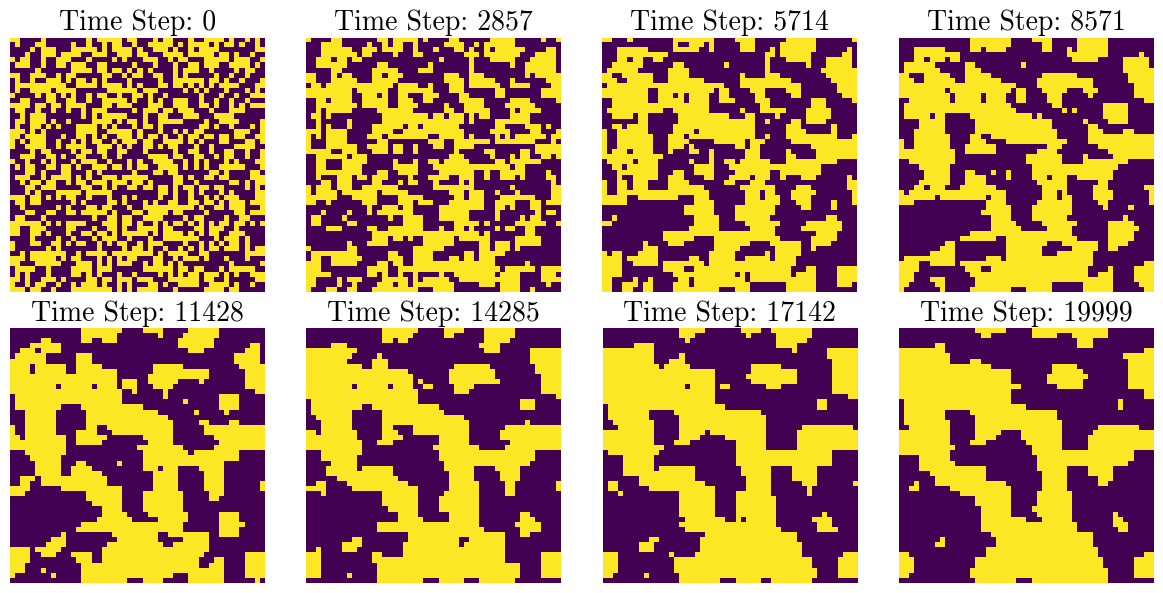

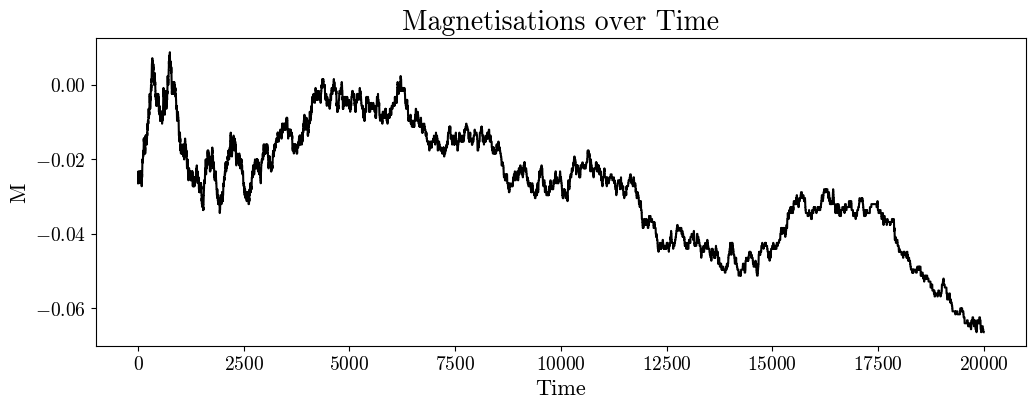

In [4]:
# Sense check: simulation for one J value

time = 20000
j = 2
bias = 0.5
L = 50

plot_lattice_evolution(time, L, j, bias)

### Run simulation

In [5]:
def run_single_simulation(L, time, j, sampleSize, bias=0.5):
    """ 
    Run a single simulation of the Metropolis algorithm.
    
    Parameters:
    L (int): The size of the lattice.
    time (int): The number of time steps to run the simulation.
    j (float): The coupling strength.
    bias (float, optional): The bias for initialising the lattice. Defaults to 0.5.
    
    Returns:
    tuple: A tuple containing the arrays S, A, SNext, magnetisations, and the last lattice.
    """
    lattice = initialise(L, bias=bias)  # initialize lattice
    senses, actions, sensesNext, magnetisations, _ = metropolis(lattice, time, j, get_mu(lattice))  # run one simulation
    return senses[-sampleSize:], actions[-sampleSize:], sensesNext[-sampleSize:], magnetisations[-sampleSize:], lattice

def run_multi_simulation(L, time, j, sampleSize, numSims, bias=0.5, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(delayed(run_single_simulation)(L, time, j, sampleSize, bias=bias) for _ in range(numSims))
    return results

## 2. Compute intrinsic utilities

### 2.1 Predictive information
Compute predictive information and plot values w.r.t. J

Each simulation:
- the transient period will be disregarded.
- the last k timesteps are sampled (assuming at equilibrium). Returning k pairs of (St, St+1).
- I(St,St+1) are computed based on the k samples from this simulation.

The estimate of $\mathcal{I}(J) = \sum_{sims}(\mathcal{I}(J))/num\_sims$

In [6]:
def mutual_information(source, destination, sourceBase, destinationBase):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(sourceBase, destinationBase, 0) # use timeDiff = 0
    # 2. No other properties to set for discrete calculators.
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()

    # 4. Supply the sample data:
    # check input dimension:
    if source.ndim >1:
        for k in range(source.shape[1]):
            src = JArray(JInt, 1)(source[:,k].tolist())
            dest = JArray(JInt, 1)(destination[:,k].tolist())
            calc.addObservations(src, dest)
    else:
        src = JArray(JInt, 1)(source.tolist())
        dest = JArray(JInt, 1)(destination.tolist())
        calc.addObservations(src, dest)  
            
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

def entropy(source, sourceBase):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").EntropyCalculatorDiscrete
    calc = calcClass(sourceBase)
    # 2. No other properties to set for discrete calculators.
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()

    # 4. Supply the sample data:
    # check input dimension:
    if source.ndim >1:
        for k in range(source.shape[1]):
            # 0. Load/prepare the data:
            src = JArray(JInt, 1)(source[:,k].tolist())
            calc.addObservations(src)
    else:
        src = JArray(JInt, 1)(source.tolist())
        calc.addObservations(src)  
        
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations() #unit = bits
    return result

def conditional_entropy(source, condition, sourceBase, conditionBase):
    entropySource = entropy(source, sourceBase) #H(S)
    miSourceCondition = mutual_information(source, condition, sourceBase, conditionBase) #I(S;C)
    condEntropy = entropySource - miSourceCondition # H(S|C) = H(S) - I(S;C)
    return condEntropy

def get_pred_info(sensory, nextSensory):
    offset = 4 # need to offset {-4,-2,0,2,4} to {0,1,2,3,4} for the base
    base = 2 * offset + 1
    predInfo = mutual_information(nextSensory + offset, sensory + offset, base, base)
    return predInfo

def get_sensory_entropy(sensory):
    offset = 4 # need to offset {-4,-2,0,2,4} to {0,1,2,3,4} for the base
    base = 2 * offset + 1
    sensoryEntropy = entropy(sensory + offset, base)
    return sensoryEntropy


Check if PI makes sense:
where J is very low (assume beta=1), all the sites starts to jiggle. As J->0, p(flip)->1, and we shall observe $(S_t,S_{t+1}) = (s,-s)$ almost all of the time. $I(S_t,S_{t+1})$ is therefore maximized, and approximately $H(S_t)$ = log2(#values of s) = log2(5) as the majority of sites are internal (i.e. with 4 neigbours), so $\sum_{<i,j>}{\sigma_i\sigma_j}\in\{-4,-2,0,2,4\}$. The conditional entropy is zero in this case.

### 2.2 Empowerment
Compute average empowerment (channel capacity) and plot values w.r.t J

Each simulation:
- the transient period will be disregarded.
- the last k timesteps are sampled (assuming at equilibrium). Returning k pairs of (At, St+1).
- I(At,St+1) are computed based on the k samples from this simulation.

The estimate of $\mathcal{E}(J) = \sum_{sims}(\mathcal{E}(J))/num\_sims$


 #### Channel capacity
 Considering an arbitrary site i in the lattice. $\sigma_i$ denotes its spin and $\mu_i=\sum_{<i,j>}{-\sigma_i\sigma_j}=\frac{E}{J}$ measures its energy (scaled by a factor J). Lower energy (i.e. negative $\mu$) or equivalently, alignment with neighbors, is preferred.

For this single site, let sensory state $S_t = \mu_i(t)$ and $A_t\in\{flip, no-flip\}$. The action channel of the site is characterised by the conditional probability p(s'|a,s), where s' is the value of the sensory state following an action, given that the site starts from S=s. If $S_t=s$, after flip/no-flip action, the only possible values for $S_{t+1}$ are {s, -s} (except that when s=0 then only one value is possible). Therefore we essentially have a channel looks like {flip, no-flip}$\rightarrow${-s, s}, and the mapping is deterministic. This is the embodiment of the site (agent).

With a binary channel like this, the channel capacity (maximum mutual information max$I(S_{t+1}, A_t)$) C(s)=1 bit, and it's achieved when the distribution between {flip, no-flip} is uniform (50/50 chance). This is true for all values of $s\in\{-4,-3,-2,-1,1,2,3,4\}$. Therefore all these states are equally empowered, if the site is free to designate its action distributions.

The channel capacity of s=0, C(0)=0, because no matter how the site acts (flip or not), it can only perceive s=0. 

Therefore, a more empowered state is where the lattice has net magnetisation $\neq0$, i.e. empoewrment is high when sites are aligned.

Let the subset of S states where channel capacity is nonzero be $\Gamma=\{-4,-3,-2,-1,1,2,3,4\}$. The average empowerment given control parameter J is: $\mathcal{E}(S;J) = \sum{p(s;J)\mathcal{E}(s)}=\sum_{s\in\Gamma}{p(s;J)\times1}$

#### Mutual information
On the other hand, we can also compute the actual mutual information (instead of its potential maximum) under the constraint of the "controller" that regulates the action distribution of the site. For a given channel s, the action distribution p(a) is:

- When s < 0: p(flip) = $e^{2\beta Js}$, p(no flip) = 1- p(flip)
- When s >= 0: p(flip) = 1, p(np flip) = 0

Hence mutual information for a given channel s: $I(S_{t+1};A_t|S_t=s) = H(S_{t+1}|S_t=s) - H(S_{t+1}|A_t, S_t=s) = H(S_{t+1}|S_t=s) = -\sum{p*logp}$ (since flip$\rightarrow$-s and no-flip$\rightarrow$s is deterministic, the conditional entropy is zero)

- When s< 0: $I(S_{t+1};A_t|S_t=s) = p(flip)*logp(flip) + p(noflip)*logp(noflip))$ 
- When s>=0: 0

Let the subset of S states where mutual information is nonzero be $\Theta = \{-4,-3,-2,-1\}$. The average mutual information given control parameter J is:
$I(S_{t+1};A_t|J) = \sum{p(s;J)I(S_{t+1};A_t|J,s)} = -\sum_{s\in\Theta}{p(s;J)\{e^{2\beta Js}*log2(e^{2\beta Js}) + (1-e^{2\beta Js})*log2(1-e^{2\beta Js})\}}$ bits

Compared with empowerment, average mutual information gives smaller weight to full alignments $H(S_{t+1}|S=-4) << 1$ when J is large (as we have a very skewed distribution of $S_{t+1}$). The larger is J, the further away is $p(a)$ from optimal $p^*(a)$ (which is 1/2, 1/2)

 is zero)

- When s< 0: $I(S_{t+1};A_t|S_t=s) = p(flip)*logp(flip) + p(noflip)*logp(noflip))$ 
- When s>=0: 0

Let the subset of S states where mutual information is nonzero be $\Theta = \{-4,-3,-2,-1\}$. The average mutual information given control parameter J is:
$I(S_{t+1};A_t|J) = \sum{p(s;J)I(S_{t+1};A_t|J,s)} = -\sum_{s\in\Theta}{p(s;J)\{e^{2\beta Js}*log2(e^{2\beta Js}) + (1-e^{2\beta Js})*log2(1-e^{2\beta Js})\}}$ bits

Compared with empowerment, average mutual information gives smaller weight to full alignments $H(S_{t+1}|S=-4) << 1$ when J is large (as we have a very skewed distribution of $S_{t+1}$). The larger is J, the further away is $p(a)$ from optimal $p^*(a)$ (which is 1/2, 1/2)

In [7]:
def get_empowerment(actions, nextSensory):
    # all non-zero states are equally empowered (1 bit) as explained in "Channel capacity" 
    return sum(nextSensory!=0)/len(nextSensory)

### 2.3 Conditional entropy (active inference intrinsic only)

Each simulation:
- the transient period will be disregarded.
- the last k timesteps are sampled (assuming at equilibrium). Returning k pairs of (At, Wt+1, St+1), where W is the global magnetisation
- H(St+1,Wt+1|At=at) are computed based on the k samples from this simulation.

The estimate of $\mathcal{F}(J) = \sum_{sims}(\mathcal{F}(J))/num\_sims$

In [8]:
def get_pdf(samples):
    sigma, counts = np.unique(samples, return_counts=True)
    p = {}
    for sig, cnt in zip(sigma, counts):
        p[sig] = cnt/samples.size
    return p

def get_free_energy(nextSensory, nextEnvironment, action, numBins=10):
    """
    Calculate the free energy as conditional entropy H(St+1, Wt+1|At=at).
    Parameters:
    nextSensory (numpy.ndarray): The sensory input for the next state.
    nextEnvironment (numpy.ndarray): The environment input for the next state.
    action (numpy.ndarray): The action taken.
    numBins (int, optional): The number of bins to use for digitizing the next environment. Defaults to 10.
    Returns:
    float: The calculated free energy.
    """

    offset = 4
    base = 4 * 2 + 1
    nextSensory_offset = nextSensory + offset
    # work out the distribution of different actions
    pA = get_pdf(action)
    # put next environment into bins
    nextEnvDigitized = np.digitize(nextEnvironment, np.linspace(-1,1,numBins), right=True) # put magnetisation [-1,1] into bins
    # compute negative conditional entropy for given A=a, then take the weighted sum across all a
    freeEnergy = 0
    for a in pA.keys():
        SNext = nextSensory_offset[action==a] # already offest to 0-8
        RNext = nextEnvDigitized[action==a] 
        freeEnergy -= pA[a] * conditional_entropy(SNext, RNext, base, numBins)
    return freeEnergy

### 2.4 Thermodynamic efficiency

$\eta$ is the ratio between rate of entropy reduction (increasing order in the collective system) and the amount of work done by changing the control parameter $\theta$, it has a unit of bit/joule. It is defined as follow:

$\eta(\theta) = -\frac{d S/d \theta}{d W/d \theta} = - \frac{d S/d \theta}{\int F(\theta)d\theta}$

where S is entropy of the system, $\theta$ is control parameter, W is work done by changing the control parameter. The denominator is equivalent to integrating fisher information w.r.t the control parameter.

To compute $\eta$, we need the following quantities:

- configuration entropy of the system $S(\underline{\sigma}; \theta)$, where $\underline{\sigma} = \{\sigma_1, ..., \sigma_{N*N}\}$
- derivative of entropy w.r.t. $\theta$
- Fisher information of control parameter \theta $F(\theta) = 4*\sum_{x}{(\frac{\sqrt{p(x;\theta+\delta \theta)} - \sqrt{p(x;\theta-\delta \theta)}}{2\delta \theta})^2}$
- integral of fisher information w.r.t. $\theta$

Each simulation:
- the transient period will be disregarded.
- the last k timesteps are sampled (assuming at equilibrium). Returning the average of k magnetisation values $\bar{m}$.
- Configuration entropy of this simulation $\mathcal{S}_n$ and $p(x;\theta)$ is computed based on the final configuration at the end of the simulation

The estimate of $\mathcal{S}(\theta) = \sum_{sims}(\mathcal{S}(\theta))/num\_sims$. $\eta$ is computed given configuration entropy $\mathcal{S}(\theta)$ and equilibrium distribution $p(x;\theta)$ as functions of $\theta$.

In [9]:
# Compute thermodynamic efficiency
def compute_probability_distribution(lattice, n, m):
    """
    Compute the probability distribution of configurations in a given nxm area
    in a wrapped around square lattice.
    
    Parameters:
    lattice (np.ndarray): A 10x10 numpy array with values -1 or 1.
    n (int): The number of rows in the area.
    m (int): The number of columns in the area.
    
    Returns:
    dict: A dictionary with configurations as keys and their probabilities as values.
    """
    L = lattice.shape[0]
    count_dict = defaultdict(int)
    
    for i in range(L):
        for j in range(L):
            # Extract the nxm sub-lattice starting at (i, j)
            sub_lattice = tuple(tuple(lattice[(i + x) % L, (j + y) % L] for y in range(m)) for x in range(n))
            count_dict[sub_lattice] += 1

    # Compute the probability distribution
    total_counts = sum(count_dict.values())
    prob_distribution = {k: v / total_counts for k, v in count_dict.items()}
    
    return prob_distribution

def compute_entropy(prob_distribution):
    """
    Compute the entropy of a given probability distribution.
    
    Parameters:
    prob_distribution (dict): A dictionary with probabilities.
    
    Returns:
    float: The entropy value.
    """
    entropy = -sum(p * np.log2(p) for p in prob_distribution.values() if p > EPSILON)
    return entropy

def get_entropy_kikuchi(lattice):
    """ 
    Compute configuration entropy using kikuchi approximation S = S1-2*S2+S4.

    Parameters:
    lattice (np.array): A 2D integer array of the LxL squre lattice. Values +/-1.
    
    Returns:
    float: The entropy value.
    """
    # compute kikuchi approx 
    entp1 = compute_entropy(compute_probability_distribution(lattice, 1, 1))
    entp2 = compute_entropy(compute_probability_distribution(lattice, 1, 2))
    entp4 = compute_entropy(compute_probability_distribution(lattice, 2, 2))
    return entp1 - 2 * entp2 + entp4

def get_entropy_meanfield(pdf):
    """ 
    Compute configuration entropy using meanfield approximation S = sum(-1,1) -p*log(p).

    Parameters:
    pdf (dict): Proability distribution {spin:p(spin)}. This can be an average distribution computed over 
                a period of time and (or) mutltiple simulations.
    
    Returns:
    float: The entropy value.
    """
    # compute mean-field approx 
    return -sum(p * np.log2(p) for p in pdf.values() if p > EPSILON)
    
def get_fisher(pdf, method = 'sqrt'):
    """
    Compute fisher information using two different methods. Default is square-root approximation because it is more stable when p is small.

    Parameters:
    pdf (dict): A dictionary {theta: f(x)}, where f(x) is also a dictionary ({x:p(x)}). Density function takes the form f(x;theta), 
                and theta is the parameter with respect to which we compute the fisher information. Assume theta is uniformly spaced. 
                For continuous distribution make sure samples are binned and normalised.
    
    Returns:
    dict: Fisher information of different Js.
    """
    thetas = np.array(list(pdf.keys()))
    fisher = {}

    # Convert pdf dictionaries to arrays
    x_values = np.array(list(pdf[thetas[0]].keys()))
    p_values = np.array([[pdf[theta].get(x, 0) for x in x_values] for theta in thetas])

    if method == 'sqrt':
        # Compute the square root of p_values
        sqrt_p_values = np.sqrt(p_values)
    
        # Compute the gradient of sqrt_p_values with respect to theta
        dsqrtp_dtheta = np.gradient(sqrt_p_values, thetas, axis=0)
    
        # Compute Fisher Information for each theta
        for i, theta in enumerate(thetas):
            fisher[theta] = 4* np.sum(dsqrtp_dtheta[i]**2)
    else: 
        # using original sum_x {(dp_dtheta)^2 / p}
        # Compute the gradient of p_values with respect to theta. Use dp_dtheta is more stable than dlogp_dtheta when p is small
        dp_dtheta = np.gradient(p_values, thetas, axis=0)
        
        # Compute Fisher Information for each theta
        for i, theta in enumerate(thetas):
            # Avoid division by zero, sum over x
            valid_mask = p_values[i] > 0
            fisher[theta] = np.sum((dp_dtheta[i][valid_mask]**2) / p_values[i][valid_mask])
    return fisher
    
def get_efficiency(configEntropy, magnetisations, fisherMethod='sqrt', entropyFilt=False, derivativeFilt=False, fisherFilt=False, integralFilt=False, pdfFilter=False, window=15, theta_star=None, threshold=None):
    """
    Compute thermodynamic efficiency. Interpolate from where fisherInfo < threshold to theta_star. Change return eta to np.array.
    
    Parameters:
    configEntropy (dict): A dictionary with parameter and configuration entropy.
    fisherInfo (dict): A dictionary with parameter and Fisher information.
    entropyFilt, derivativeFilt, fisherFilt, integralFilt (bool): switches for filters (Savitzky-Golay filter).
    window (int): window size for the filter.
    
    Returns:
    np.array: thermodynamic efficiency eta;
    np.array: configuration entropy values extracted from configEntropy, for checking;
    np.array: numerators for each eta, for checking;
    np.array: fisher information values extracted from fisherInfo, for checking;
    np.array: denominators for each eta, for checking.
    """
    theta = np.array(list(configEntropy.keys()))
    hx = np.array(list(configEntropy.values()))

    # Check if smoothing magnetisation is on:
    if pdfFilter:
        mask = theta > CRITICAL_VALUE # mask for J > Jc
        filtered_section = savgol_filter(magnetisations[mask], window_length=20, polyorder=1)
        mm = np.copy(magnetisations)
        mm[mask] = filtered_section
    else:
        mm = np.copy(magnetisations)

    # Retrieve average pdf for each J  
    pdfs = {} # pdf for each J
    for theta_idx, theta_val in enumerate(theta):
        Mbar = mm[theta_idx]
        pdfs[theta_val] = {1:(1 + Mbar) / 2, -1:(1 - Mbar) / 2}

    # Compute fisher information given pdfs for different Js
    fisherInfo = get_fisher(pdfs, method=fisherMethod)
    fisher = np.array(list(fisherInfo.values()))
    
    # Values to keep
    denominator = np.empty(len(hx)) 

    # Check if sum to theta_star is on
    if (theta_star != None) and (theta_star > theta.max()):
        theta = np.append(theta, theta_star)
        fisher = np.append(fisher, 0) # assume theta_star correspond to zero fisher information

        # interpolate between fi_small and fi_thetastar (to remove noise)
        if (threshold != None) and (threshold > 0):
            start_index = np.where(fisher > threshold)[0][-1] # find the last index where fisher > threshold
            x = np.append(theta[start_index], theta[-1]) # define starting and end point for interpolation
            y = np.append(fisher[start_index], fisher[-1]) # define starting and end point for interpolation
            interp_func = interp1d(x, y, kind='linear') # Create the interpolation function
            x_interp = theta[start_index:] # Define the range of x values to interpolate over
            y_interp = interp_func(x_interp) # Perform the interpolation
            fisher = np.append(fisher[:start_index], y_interp)

    # apply filters: entropy, fisher
    if entropyFilt:
        hx = savgol_filter(hx, window_length=window, polyorder=1)
    if fisherFilt:
        fisher = savgol_filter(fisher, window_length=window, polyorder=1)
    
    # compute numerator, denominator
    numerator = np.gradient(hx,theta[:len(hx)])
    for i in range(len(hx)):
        denominator[i] = np.trapz(fisher[i:], theta[i:]) # integrate from theta0 to point to zero-response 10
    
    # apply filters: derivative, integral
    if derivativeFilt:
        numerator = savgol_filter(numerator, window_length=window, polyorder=1)
    if integralFilt:
        denominator = savgol_filter(denominator, window_length=window, polyorder=1)
    
    # compute eta
    mask = (abs(denominator) < EPSILON) | (abs(numerator) < EPSILON)
    eta = np.zeros_like(numerator)
    eta[~mask] = -numerator[~mask] / denominator[~mask]
    return eta, hx, numerator, fisher, denominator, mm

### 2.5 Compute all utilities

In [10]:
def unpack_results(results):
    senses_array = np.array([result[0].astype(int) for result in results])
    actions_array = np.array([result[1].astype(int) for result in results])
    sensesNext_array = np.array([result[2].astype(int) for result in results])
    magnetisations_array = np.array([result[3] for result in results])
    lattice_array = np.array([result[4].astype(int) for result in results])
    return senses_array, actions_array, sensesNext_array, magnetisations_array, lattice_array

def compute_all_intrinsic_utilities(results, subSample, method='kikuchi', absolute_m=True):
    """
    Compute all intrinsic utilities for a given j value.
    
    Parameters:
    results (list): A list of simulation results, where each result is a tuple containing the arrays of sensory input, actions, next sensory input, magnetisations, and lattice at the end of each simulation. 
    method (str): The method to use for computing configuration entropy (thermodynamic efficiency). Defaults to 'kikuchi'.
    absolute_m (bool): Whether to take the absolute value of magnetisation for Fisher Information (thermodynamic efficiency). Defaults to True.
    
    Returns:
    tuple: A tuple containing the mean values of predictive information, empowerment, free energy, configuration entropy, and average magnetisation across all simulations.
    """
    senses_array, actions_array, sensesNext_array, magnetisations_array, lattice_array = unpack_results(results)
    numSims = len(senses_array) # each element in the array is a list of samples collected for one simulation. Length of the array is the number of simulations.
    pi = np.zeros(numSims) # predictive information for each simulation
    se = np.zeros(numSims) # sensory entropy for each simulation
    ep = np.zeros(numSims) # empowerment for each simulation
    fe = np.zeros(numSims) # free energy for each simulation
    hx = np.zeros(numSims) # configuration entropy for each simulation
    mm = np.zeros(numSims) # average magnetisation for each simulation
        
    for i in range(numSims):
        pi[i] = get_pred_info(senses_array[i], sensesNext_array[i])
        se[i] = get_sensory_entropy(sensesNext_array[i]) 
        ep[i] = get_empowerment(actions_array[i], sensesNext_array[i])
        fe[i] = get_free_energy(sensesNext_array[i], magnetisations_array[i], actions_array[i])
        # average magnetisation each simulation
        # magnetisation is sampled every subSample time steps because it is highly correlated
        if absolute_m:
            mm[i] = np.mean(abs(magnetisations_array[i][:][::subSample]))
        else:
            mm[i] = np.mean(magnetisations_array[i][:][::subSample])
        # configuration entropy each simulation
        if method == 'kikuchi':
            hx[i] = get_entropy_kikuchi(lattice_array[i])
        else:   
            pdf = {1:(1 + mm[i]) / 2, -1:(1 - mm[i]) / 2}
            hx[i] = get_entropy_meanfield(pdf)
    return np.mean(pi), np.mean(se), np.mean(ep), np.mean(fe), np.mean(hx), np.mean(mm)

## 3. Analysis

In [11]:
# Run simulations and analysis
# parameters for simulation
L = 50
time = 20200000 # perform 20.2mil flips
Js = np.linspace(0.01,2,100)
sampleSize = 200000 # take 200k observations to compute pi, emp, fe
subSample = L*L # sample every sweep for magnetisation
numSims = 20 # number of simulations
bias = 0.5

# parameters for computing intrinsic utilities
absolute_m = True # use absolute value of magnetisation for fisher information
theta_star = 10 # theta_star for thermodynamic efficiency upper bound
threshold = 5e-2 # threshold for interpolation in fisher information integral

# initialise arrays to store results
pred_info = np.zeros_like(Js) # predictive information
sens_entp = np.zeros_like(Js) # sensory entropy
empw_vals = np.zeros_like(Js) # empowerment
free_engy = np.zeros_like(Js) # free energy
cnfg_entp = np.zeros_like(Js) # configuration entropy
avrg_magt = np.zeros_like(Js) # average magnetisation
pdf_dict = {} # pdf for each J
cnfg_entp_dict = {} # average configuration entropy for each J

# run simulations for different J values
for i, J in enumerate(Js):
    results = run_multi_simulation(L, time, J, sampleSize, numSims, bias=bias)
    pred_info[i], sens_entp[i], empw_vals[i], free_engy[i], cnfg_entp[i], avrg_magt[i] = compute_all_intrinsic_utilities(results, subSample, method='kikuchi', absolute_m=absolute_m)
    cnfg_entp_dict[J] = cnfg_entp[i]

# compute thermodynamic efficiency
result_eta,_,_,_,_, result_mag = get_efficiency(cnfg_entp_dict, avrg_magt, fisherMethod='sqrt', derivativeFilt=True, pdfFilter=True, window=15, theta_star=theta_star, threshold=threshold)

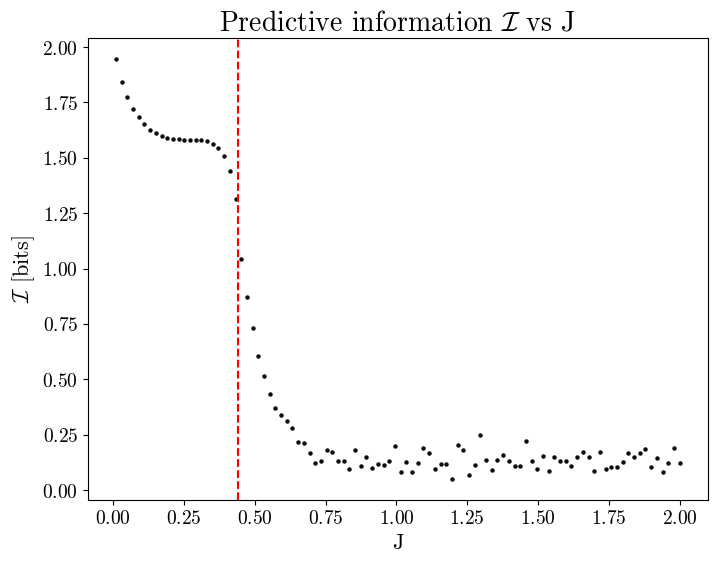

In [12]:
# Make plots
# predictive information
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(Js, pred_info, s=5, color='k', alpha=0.9);
plt.axvline(x=CRITICAL_VALUE, color='r', linestyle='--', label='Indicates $J_c$');
plt.title(r'Predictive information $\mathcal{I}$ vs J');
plt.ylabel(r'$\mathcal{I}$ [bits]');
plt.xlabel('J');
plt.savefig('pi_v_J.png', dpi=300)  # dpi=300 for high resolution

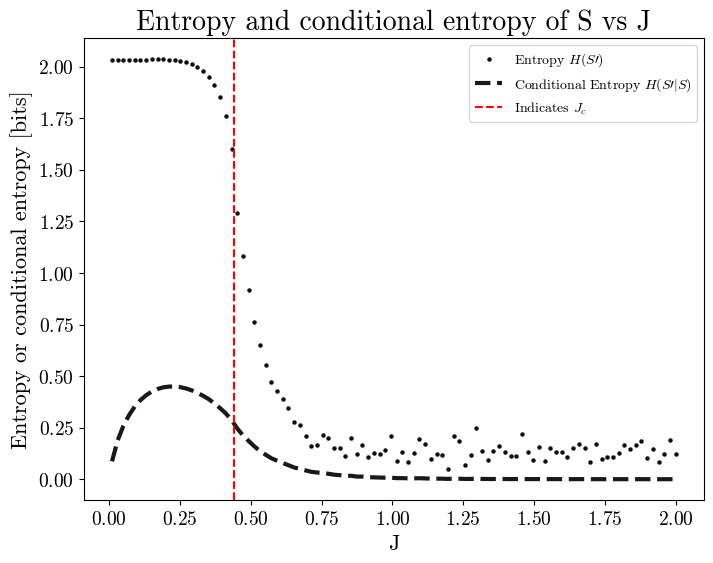

In [13]:
# decomposition of predictive information
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(Js, sens_entp, s=20,color='k', marker='.', alpha=0.9, label=r'Entropy $H(S\prime)$');
plt.plot(Js, sens_entp - pred_info,c='k', linewidth=3, linestyle='--', alpha=0.9, label=r'Conditional Entropy $H(S\prime|S)$');
plt.axvline(x=CRITICAL_VALUE, color='r', linestyle='--', label='Indicates $J_c$');
plt.title('Entropy and conditional entropy of S vs J');
plt.ylabel(r'Entropy or conditional entropy [bits]');
plt.xlabel('J');
plt.legend();
plt.savefig('hs_v_J.png', dpi=300)  # dpi=300 for high resolution

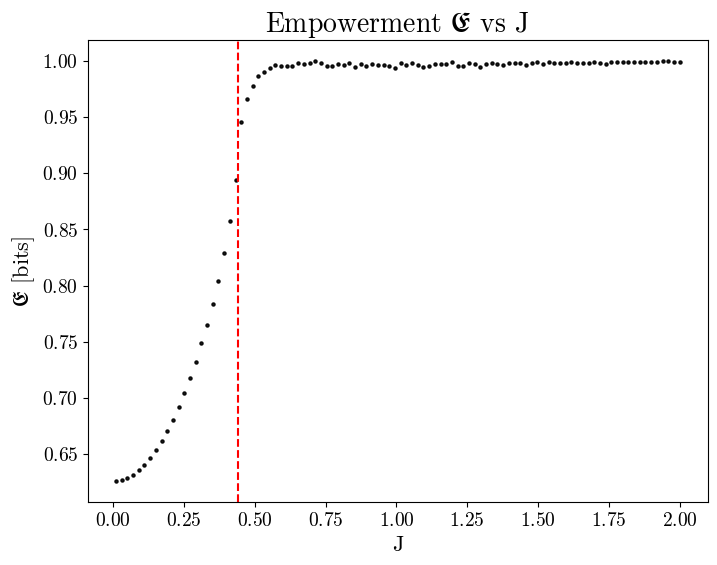

In [14]:
# empowerment
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(Js, empw_vals,s=5, color='k', alpha=0.9);
plt.axvline(x=CRITICAL_VALUE, color='r', linestyle='--', label='Indicates $J_c$');
plt.title(r'Empowerment $\mathfrak{E}$ vs J');
plt.ylabel(r'$\mathfrak{E}$ [bits]');
plt.xlabel('J');
plt.savefig('emp_v_J.png', dpi=300)  # dpi=300 for high resolution

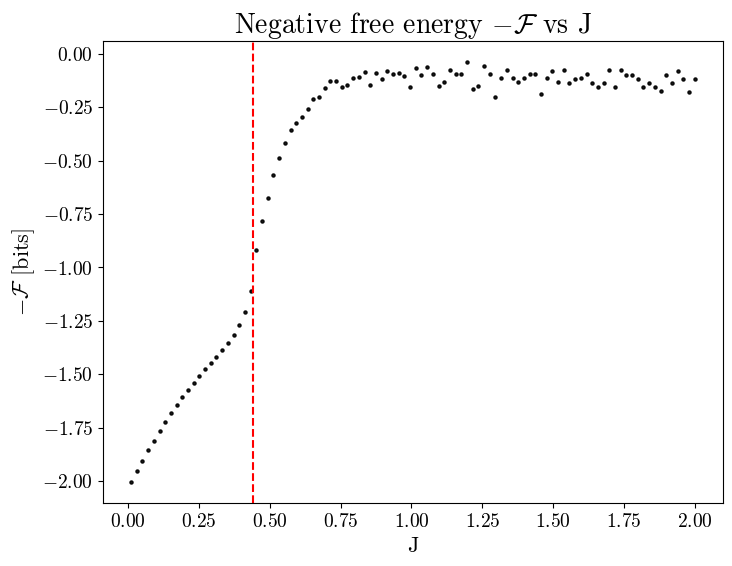

In [15]:
# free energy
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(Js, free_engy, s=5, color='k', alpha=0.9);
plt.axvline(x=CRITICAL_VALUE, color='r', linestyle='--', label='Indicates $J_c$');
plt.title(r'Negative free energy $-\mathcal{F}$ vs J');
plt.ylabel(r'$-\mathcal{F}$ [bits]');
plt.xlabel('J');
plt.savefig('nfe_v_J.png', dpi=300)  # dpi=300 for high resolution

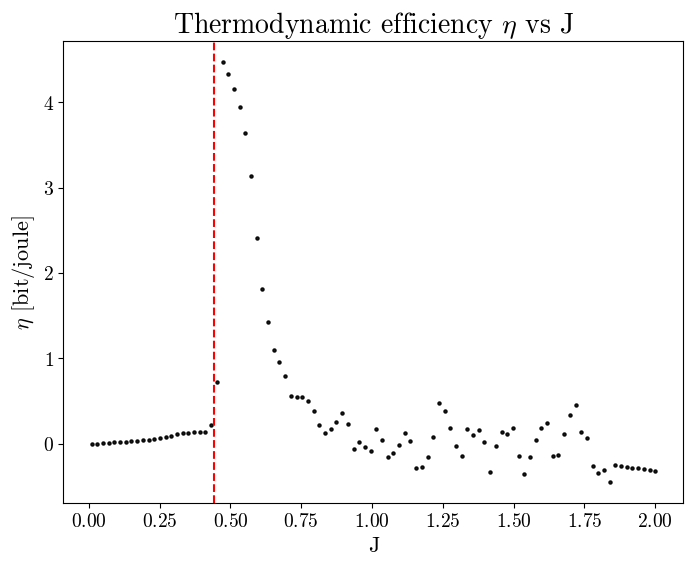

In [16]:
# Thermodynamic efficiency
plt.figure(figsize=(8, 6))  # Define the figure size
plt.scatter(Js, result_eta,s=5, color='k', alpha=0.9);
plt.axvline(x=CRITICAL_VALUE, color='r', linestyle='--', label='Indicates $p_c$');
plt.title(r'Thermodynamic efficiency $\eta$ vs J');
plt.ylabel(r'$\eta$ [bit/joule]');
plt.xlabel('J');
plt.savefig('eta_v_J.png', dpi=300)  # dpi=300 for high resolution

In [18]:
# Export data 
combined_data = {
    'L' : L,
    'time' : time,
    'Js' : Js.tolist(),
    'sampleSize' : sampleSize,
    'subSample' : subSample,
    'numSims' : numSims,
    'bias' : bias,
    'absolute_m' : absolute_m,
    'theta_star' : theta_star,
    'threshold' : threshold,
    'pred_info' : pred_info.tolist(),
    'sens_entp' : sens_entp.tolist(),
    'empw_vals' : empw_vals.tolist(),
    'free_engy' : free_engy.tolist(),
    'cnfg_entp' : cnfg_entp.tolist(),
    'avrg_magt' : avrg_magt.tolist()
}

# Save combined data to a JSON file
with open('output.json', 'w') as json_file:
    json.dump(combined_data, json_file)